In [1]:
import filterpy.stats as stats

<AxesSubplot:>

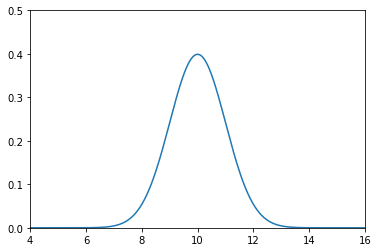

In [3]:
stats.plot_gaussian_pdf(mean=10., variance=1., xlim=(4, 16), ylim=(0, 0.5))

In [4]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

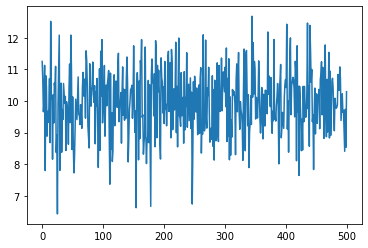

In [5]:
xs = range(500)
ys = randn(500) * 1. + 10.
plt.plot(xs, ys)

In [6]:
from collections import namedtuple

In [9]:
gaussian = namedtuple("Gaussian", ["mean", "var"])
gaussian.__repr__ = lambda s: "mu=({:.3f}) s2={:.3f}".format(s[0], s[1])

In [10]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(4.5, 0.2**2)
print(g1)
print(g2)

mu=(3.400) s2=10.100
mu=(4.500) s2=0.040


In [14]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [15]:
pos = gaussian(10, 0.2**2)
movement = gaussian(15, 0.7**2)
predict(pos, movement)

mu=(25.000) s2=0.530

In [17]:
def gaussianMultiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    var = (g1.var * g2.var)/(g1.var + g2.var)
    return gaussian(mean, var)

In [18]:
def update(prior, likelihood):
    posterior = gaussianMultiply(prior, likelihood)
    return posterior

In [19]:
predicted_pos = gaussian(10., 0.2**2)
measured_pos = gaussian(11., 0.1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

mu=(10.800) s2=0.008

In [20]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation

In [23]:
process_var = 1.0
sensors_var = 2.0

x = gaussian(0, 20.**2)
velocity = 1
dt = 1
process_model = gaussian(velocity*dt, process_var)

dog = DogSimulation(
    x0 = x.mean,
    velocity=process_model.mean,
    measurement_var=sensors_var,
    process_var=process_model.var
)
zs = [dog.move_and_sense() for _ in range(10)]


In [24]:
for z in zs:
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensors_var)
    posterior = update(likelihood, prior)
    kf_internal.print_gh(prior, x, z)

  1.000  401.000	0.830	  0.000  400.000
  1.000  401.000	3.924	  0.000  400.000
  1.000  401.000	3.251	  0.000  400.000
  1.000  401.000	6.430	  0.000  400.000
  1.000  401.000	8.434	  0.000  400.000
  1.000  401.000	10.936	  0.000  400.000
  1.000  401.000	7.602	  0.000  400.000
  1.000  401.000	14.279	  0.000  400.000
  1.000  401.000	12.530	  0.000  400.000
  1.000  401.000	7.687	  0.000  400.000


In [25]:
def update(prior, measurement):
    x, P = prior # mean and var
    z, R = measurement # mean and var
    y = z - x
    K = P/(P+R)
    x = x + K*y
    P = (1 - K) * P
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior
    dx, Q = movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)